In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import json

In [2]:
# Define the data folder path
folder_path = './data/question_1a'
file_type = ".json"

with open(f'{folder_path}/appliance_params{file_type}', 'r') as f:
    appliance_params = json.load(f)

with open(f'{folder_path}/bus_params{file_type}', 'r') as f:
    bus_params = json.load(f)

with open(f'{folder_path}/consumer_params{file_type}', 'r') as f:
    consumer_params = json.load(f)

with open(f'{folder_path}/DER_production{file_type}', 'r') as f:
    DER_production = json.load(f)

with open(f'{folder_path}/usage_preference{file_type}', 'r') as f:
    usage_preference = json.load(f)


In [3]:
#System Parameters
bus_data = bus_params[0]
tau_imp = bus_data['import_tariff_DKK/kWh']
tau_exp = bus_data['export_tariff_DKK/kWh']
max_import = bus_data['max_import_kW']
max_export = bus_data['max_export_kW']
electricity_prices = bus_data['energy_price_DKK_per_kWh']

In [4]:
#PV parameters
pv_data = appliance_params['DER'][0]
pv_max_power = pv_data['max_power_kW']
pv_profile = DER_production[0]['hourly_profile_ratio']
pv_prod_hourly = [pv_max_power * ratio for ratio in pv_profile] # PV production per hour (kW) (No curtailment)

In [5]:
#Load parameters
load_data = appliance_params['load'][0]
E_min = usage_preference[0]['load_preferences'][0]['min_total_energy_per_day_hour_equivalent'] # Minimum daily consumption (kWh)
max_load_per_hour = load_data['max_load_kWh_per_hour']  # Maximum load per hour (kW)

In [6]:
#Temporal parameters
T = len(electricity_prices)  # 24 hours
Times = range(T) # Time horizon (24 hours)

In [7]:
model = gp.Model("Energy_Optimization")

# Decision variables:
L_t = model.addVars(Times, lb=0, name="L_t")  # Load consumption (kW)
C_t = model.addVars(Times, lb=0, name="C_t")  # Energy curtailed from PV (kW)
G_imp_t = model.addVars(Times, lb=0, ub=max_import, name="G_imp_t")  # Grid import (kW)
G_exp_t = model.addVars(Times, lb=0, ub=max_export, name="G_exp_t")  # Grid export (kW)

# Binary variables for mutual exclusivity of import/export
b_imp_t = model.addVars(Times, vtype=GRB.BINARY, name="b_imp_t")  # 1 if importing, 0 otherwise
b_exp_t = model.addVars(Times, vtype=GRB.BINARY, name="b_exp_t")  # 1 if exporting, 0 otherwise

Set parameter Username
Set parameter LicenseID to value 2670718
Academic license - for non-commercial use only - expires 2026-05-26
Set parameter LicenseID to value 2670718
Academic license - for non-commercial use only - expires 2026-05-26


In [8]:
#Objective function
# Minimize: Import Cost - Export Revenue
# Import Cost = G_imp * (tau_imp + price)
# Export Revenue = G_exp * (price - tau_exp)
model.setObjective(
    gp.quicksum(G_imp_t[t] * (tau_imp + electricity_prices[t]) - 
                G_exp_t[t] * (electricity_prices[t] - tau_exp) for t in Times),
    GRB.MINIMIZE
)

In [9]:
#add constraints

# Curtailment constraint: Cannot curtail more than PV produces
Curtailment_constraint = [
	model.addLConstr(C_t[t] <= pv_prod_hourly[t], name=f"Curtailment_{t}")
	for t in Times
]

# Load coverage constraint: Total daily load must meet minimum requirement
Load_coverage_constraint = [
	model.addLConstr(gp.quicksum(L_t[t] for t in Times) >= E_min, name=f"Total_Load_Coverage")
	for t in Times
]

# Max hourly load constraint: Load cannot exceed maximum per hour
Max_hourly_load_constraint = [
	model.addLConstr(L_t[t] <= max_load_per_hour, name=f"Max_Load_{t}")
	for t in Times
]

# Mutual exclusivity: Cannot import and export simultaneously
Mutual_exclusivity_constraint = [
	model.addLConstr(b_imp_t[t] + b_exp_t[t] <= 1, name=f"Mutual_Exclusivity_{t}")
	for t in Times
]

# Link binary variables to import/export (big-M constraints)
Import_binary_constraint = [
	model.addLConstr(G_imp_t[t] <= max_import * b_imp_t[t], name=f"Import_Binary_{t}")
	for t in Times
]

Export_binary_constraint = [
	model.addLConstr(G_exp_t[t] <= max_export * b_exp_t[t], name=f"Export_Binary_{t}")
	for t in Times
]

# Power balance constraint
power_balance_constraint = [
	model.addLConstr(G_imp_t[t] - G_exp_t[t] == L_t[t] - pv_prod_hourly[t] + C_t[t], name=f"power_balance_{t}")
	for t in Times
]

In [10]:
#solve optimization problem
model.optimize()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 8840HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 168 rows, 144 columns and 864 nonzeros
Model fingerprint: 0x8545389f
Variable types: 96 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [4e-01, 3e+00]
  Bounds range     [1e+00, 1e+03]
  RHS range        [2e-01, 8e+00]
Found heuristic solution: objective 4.0500000

CPU model: AMD Ryzen 7 8840HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 168 rows, 144 columns and 864 nonzeros
Model fingerprint: 0x8545389f
Variable types: 96 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective rang

In [11]:
#print results
if model.status == GRB.OPTIMAL:
    print("\nOptimal solution found:")
    print(f"Total cost: {model.objVal:.2f} DKK")
    print("Hour | Load (kW) | Curtailment (kW) | Grid Import (kW) | Grid Export (kW) | PV Production (kW) | Electricity Price (DKK/kWh)")
    for t in Times:
        print(f"{t:4d} | {L_t[t].X:9.2f} | {C_t[t].X:15.2f} | {G_imp_t[t].X:15.2f} | {G_exp_t[t].X:15.2f} | {pv_prod_hourly[t]:18.2f} | {electricity_prices[t]:25.2f}")


Optimal solution found:
Total cost: -6.37 DKK
Hour | Load (kW) | Curtailment (kW) | Grid Import (kW) | Grid Export (kW) | PV Production (kW) | Electricity Price (DKK/kWh)
   0 |      0.00 |            0.00 |            0.00 |            0.00 |               0.00 |                      1.10
   1 |      0.00 |            0.00 |            0.00 |            0.00 |               0.00 |                      1.05
   2 |      0.00 |            0.00 |            0.00 |            0.00 |               0.00 |                      1.00
   3 |      0.00 |            0.00 |            0.00 |            0.00 |               0.00 |                      0.90
   4 |      0.00 |            0.00 |            0.00 |            0.00 |               0.00 |                      0.85
   5 |      0.15 |            0.00 |            0.00 |            0.00 |               0.15 |                      1.01
   6 |      0.42 |            0.00 |            0.00 |            0.00 |               0.42 |               

In [12]:
#sum L_t
print(f"\nTotal Load Consumption: {sum(L_t[t].X for t in Times):.2f} kWh")


Total Load Consumption: 8.00 kWh


# Sensitivity Analysis - Question 1.a.v

We will analyze 4 scenarios to understand system behavior under different conditions:

1. **Flat Electricity Prices** - Remove price variation to see load distribution without temporal optimization
2. **Increased Minimum Load** - Force grid imports by increasing demand beyond PV capacity
3. **Reduced PV Capacity** - Lower PV generation to 50% to analyze partial self-sufficiency
4. **Zero Grid Tariffs** - Remove import/export fees to demonstrate full energy arbitrage potential

In [13]:
# Create reusable optimization function
def run_optimization_scenario(electricity_prices_scenario, tau_imp_scenario, tau_exp_scenario, 
                               pv_prod_hourly_scenario, E_min_scenario, max_load_per_hour_scenario,
                               max_import_scenario, max_export_scenario, scenario_name):
    """
    Run optimization model for a given scenario
    
    Returns: dict with results
    """
    Times = range(len(electricity_prices_scenario))
    
    # Create model
    model = gp.Model(f"Energy_Optimization_{scenario_name}")
    model.setParam('OutputFlag', 0)  # Suppress solver output
    
    # Decision variables
    L_t = model.addVars(Times, lb=0, name="L_t")
    C_t = model.addVars(Times, lb=0, name="C_t")
    G_imp_t = model.addVars(Times, lb=0, ub=max_import_scenario, name="G_imp_t")
    G_exp_t = model.addVars(Times, lb=0, ub=max_export_scenario, name="G_exp_t")
    
    # Binary variables for mutual exclusivity of import/export
    b_imp_t = model.addVars(Times, vtype=GRB.BINARY, name="b_imp_t")
    b_exp_t = model.addVars(Times, vtype=GRB.BINARY, name="b_exp_t")
    
    # Objective function
    # Minimize: Import Cost - Export Revenue
    # Import Cost = G_imp * (tau_imp + price)
    # Export Revenue = G_exp * (price - tau_exp)
    model.setObjective(
        gp.quicksum(G_imp_t[t] * (tau_imp_scenario + electricity_prices_scenario[t]) - 
                    G_exp_t[t] * (electricity_prices_scenario[t] - tau_exp_scenario) for t in Times),
        GRB.MINIMIZE
    )
    
    # Constraints
    for t in Times:
        model.addLConstr(C_t[t] <= pv_prod_hourly_scenario[t], name=f"Curtailment_{t}")
        model.addLConstr(L_t[t] <= max_load_per_hour_scenario, name=f"Max_Load_{t}")
        
        # Mutual exclusivity: Cannot import and export simultaneously
        model.addLConstr(b_imp_t[t] + b_exp_t[t] <= 1, name=f"Mutual_Exclusivity_{t}")
        
        # Link binary variables to import/export
        model.addLConstr(G_imp_t[t] <= max_import_scenario * b_imp_t[t], name=f"Import_Binary_{t}")
        model.addLConstr(G_exp_t[t] <= max_export_scenario * b_exp_t[t], name=f"Export_Binary_{t}")
        
        model.addLConstr(G_imp_t[t] - G_exp_t[t] == L_t[t] - pv_prod_hourly_scenario[t] + C_t[t], 
                        name=f"power_balance_{t}")
    
    model.addLConstr(gp.quicksum(L_t[t] for t in Times) >= E_min_scenario, name="Total_Load_Coverage")
    
    # Solve
    model.optimize()
    
    # Extract results
    if model.status == GRB.OPTIMAL:
        results = {
            'scenario_name': scenario_name,
            'total_cost': model.objVal,
            'load': [L_t[t].X for t in Times],
            'curtailment': [C_t[t].X for t in Times],
            'grid_import': [G_imp_t[t].X for t in Times],
            'grid_export': [G_exp_t[t].X for t in Times],
            'pv_production': pv_prod_hourly_scenario,
            'electricity_prices': electricity_prices_scenario,
            'total_load': sum(L_t[t].X for t in Times),
            'total_import': sum(G_imp_t[t].X for t in Times),
            'total_export': sum(G_exp_t[t].X for t in Times),
            'total_curtailment': sum(C_t[t].X for t in Times)
        }
        return results
    else:
        print(f"Optimization failed for {scenario_name}")
        return None

## Scenario 1: Flat Electricity Prices

**Hypothesis:** Without price variation, the optimizer has no economic incentive to shift load timing. The load profile will continue to follow PV production

In [14]:
# Scenario 1: Flat Electricity Prices
flat_prices = [np.mean(electricity_prices)] * T

results_scenario1 = run_optimization_scenario(
    electricity_prices_scenario=flat_prices,
    tau_imp_scenario=tau_imp,
    tau_exp_scenario=tau_exp,
    pv_prod_hourly_scenario=pv_prod_hourly,
    E_min_scenario=E_min,
    max_load_per_hour_scenario=max_load_per_hour,
    max_import_scenario=max_import,
    max_export_scenario=max_export,
    scenario_name="Scenario_1"
)

print(f"\n{'='*80}")
print(f"SCENARIO 1: FLAT ELECTRICITY PRICES")
print(f"{'='*80}")
print(f"Flat price used: {flat_prices[0]:.4f} DKK/kWh")
print(f"Total cost: {results_scenario1['total_cost']:.2f} DKK")
print(f"Total load: {results_scenario1['total_load']:.2f} kWh")
print(f"Total grid import: {results_scenario1['total_import']:.2f} kWh")
print(f"Total grid export: {results_scenario1['total_export']:.2f} kWh")
print(f"Total curtailment: {results_scenario1['total_curtailment']:.2f} kWh")


SCENARIO 1: FLAT ELECTRICITY PRICES
Flat price used: 1.3192 DKK/kWh
Total cost: -5.03 DKK
Total load: 8.00 kWh
Total grid import: 0.00 kWh
Total grid export: 5.47 kWh
Total curtailment: 0.00 kWh


## Scenario 2: Increased Minimum Load

**Hypothesis:** If E_min exceeds total daily PV production, the system must import from the grid. This will force price-responsive behavior - load will concentrate in cheap-price hours AND during PV production to minimize import costs.

In [15]:
# Scenario 2: Increased Minimum Load (2x total PV production)
total_pv_production = sum(pv_prod_hourly)
E_min_high = 2 * total_pv_production

results_scenario2 = run_optimization_scenario(
    electricity_prices_scenario=electricity_prices,
    tau_imp_scenario=tau_imp,
    tau_exp_scenario=tau_exp,
    pv_prod_hourly_scenario=pv_prod_hourly,
    E_min_scenario=E_min_high,
    max_load_per_hour_scenario=max_load_per_hour,
    max_import_scenario=max_import,
    max_export_scenario=max_export,
    scenario_name="Scenario_2"
)

print(f"\n{'='*80}")
print(f"SCENARIO 2: INCREASED MINIMUM LOAD")
print(f"{'='*80}")
print(f"Original E_min: {E_min:.2f} kWh")
print(f"New E_min: {E_min_high:.2f} kWh (2x total PV production)")
print(f"Total PV production: {total_pv_production:.2f} kWh")
print(f"Total cost: {results_scenario2['total_cost']:.2f} DKK")
print(f"Total load: {results_scenario2['total_load']:.2f} kWh")
print(f"Total grid import: {results_scenario2['total_import']:.2f} kWh")
print(f"Total grid export: {results_scenario2['total_export']:.2f} kWh")
print(f"Total curtailment: {results_scenario2['total_curtailment']:.2f} kWh")


SCENARIO 2: INCREASED MINIMUM LOAD
Original E_min: 8.00 kWh
New E_min: 26.94 kWh (2x total PV production)
Total PV production: 13.47 kWh
Total cost: 18.81 DKK
Total load: 26.94 kWh
Total grid import: 14.97 kWh
Total grid export: 1.50 kWh
Total curtailment: 0.00 kWh


## Scenario 3: Reduced PV Capacity (50%)

**Hypothesis:** Lower PV production forces partial grid reliance. Load will still shift to PV hours, but grid imports will occur during high-PV hours at low prices. This shows how PV sizing affects self-sufficiency.

In [16]:
# Scenario 3: Reduced PV Capacity (50% of original)
pv_prod_hourly_reduced = [p * 0.5 for p in pv_prod_hourly]

results_scenario4 = run_optimization_scenario(
    electricity_prices_scenario=electricity_prices,
    tau_imp_scenario=tau_imp,
    tau_exp_scenario=tau_exp,
    pv_prod_hourly_scenario=pv_prod_hourly_reduced,
    E_min_scenario=E_min,
    max_load_per_hour_scenario=max_load_per_hour,
    max_import_scenario=max_import,
    max_export_scenario=max_export,
    scenario_name="Scenario_3"
)

print(f"\n{'='*80}")
print(f"SCENARIO 3: REDUCED PV CAPACITY (50%)")
print(f"{'='*80}")
print(f"Original total PV: {sum(pv_prod_hourly):.2f} kWh")
print(f"Reduced total PV: {sum(pv_prod_hourly_reduced):.2f} kWh")
print(f"Total cost: {results_scenario4['total_cost']:.2f} DKK")
print(f"Total load: {results_scenario4['total_load']:.2f} kWh")
print(f"Total grid import: {results_scenario4['total_import']:.2f} kWh")
print(f"Total grid export: {results_scenario4['total_export']:.2f} kWh")
print(f"Total curtailment: {results_scenario4['total_curtailment']:.2f} kWh")


SCENARIO 3: REDUCED PV CAPACITY (50%)
Original total PV: 13.47 kWh
Reduced total PV: 6.73 kWh
Total cost: 1.30 DKK
Total load: 8.00 kWh
Total grid import: 2.02 kWh
Total grid export: 0.75 kWh
Total curtailment: 0.00 kWh


## Scenario 4: Zero Grid Tariffs (Full Energy Arbitrage)

**Hypothesis:** Without import/export tariffs, the system can profit from energy arbitrage. The optimizer will import during low-price hours and export during high-price hours to maximize profit, independent of load scheduling. This shows the maximum arbitrage potential when grid fees are eliminated.

In [17]:
# Scenario 4: Zero Grid Tariffs (Full Energy Arbitrage)
# Set import and export tariffs to zero
tau_imp_zero = 0.0
tau_exp_zero = 0.0

results_scenario5 = run_optimization_scenario(
    electricity_prices_scenario=electricity_prices,
    tau_imp_scenario=tau_imp_zero,
    tau_exp_scenario=tau_exp_zero,
    pv_prod_hourly_scenario=pv_prod_hourly,
    E_min_scenario=E_min,
    max_load_per_hour_scenario=max_load_per_hour,
    max_import_scenario=max_import,
    max_export_scenario=max_export,
    scenario_name="Scenario_4"
)

print(f"\n{'='*80}")
print(f"SCENARIO 4: ZERO GRID TARIFFS (FULL ENERGY ARBITRAGE)")
print(f"{'='*80}")
print(f"Import tariff: {tau_imp_zero:.2f} DKK/kWh (original: {tau_imp:.2f})")
print(f"Export tariff: {tau_exp_zero:.2f} DKK/kWh (original: {tau_exp:.2f})")
print(f"Total cost: {results_scenario5['total_cost']:.2f} DKK")
print(f"Total load: {results_scenario5['total_load']:.2f} kWh")
print(f"Total grid import: {results_scenario5['total_import']:.2f} kWh")
print(f"Total grid export: {results_scenario5['total_export']:.2f} kWh")
print(f"Total curtailment: {results_scenario5['total_curtailment']:.2f} kWh")
print(f"\nNet grid interaction: {results_scenario5['total_import'] - results_scenario5['total_export']:.2f} kWh")
if results_scenario5['total_cost'] < 0:
    print(f"PROFIT from arbitrage: {abs(results_scenario5['total_cost']):.2f} DKK")
else:
    print(f"Net cost: {results_scenario5['total_cost']:.2f} DKK")


SCENARIO 4: ZERO GRID TARIFFS (FULL ENERGY ARBITRAGE)
Import tariff: 0.00 DKK/kWh (original: 0.50)
Export tariff: 0.00 DKK/kWh (original: 0.40)
Total cost: -9.46 DKK
Total load: 8.00 kWh
Total grid import: 6.35 kWh
Total grid export: 11.82 kWh
Total curtailment: 0.00 kWh

Net grid interaction: -5.47 kWh
PROFIT from arbitrage: 9.46 DKK


## Visualization of Results

In [18]:
# Visualization settings
Grid_plot_var = True  # Set to True to show grid import/export, False to hide

def plot_scenario_results(results, base_results=None, title="Scenario Results"):
    """
    Plot PV production, load profile, electricity prices, and optionally grid import/export
    
    Args:
        results: Dictionary with scenario results
        base_results: Optional base case results for comparison
        title: Plot title
    """
    hours = range(len(results['load']))
    
    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    # Plot PV production (yellow filled area, semi-transparent)
    ax1.fill_between(hours, results['pv_production'], alpha=0.3, color='yellow', 
                     label='PV Production', edgecolor='orange', linewidth=1.5)
    
    # Plot load profile
    ax1.plot(hours, results['load'], color='blue', linewidth=2.5, 
             label='Load Profile', marker='o', markersize=4)
    
    # Plot base case load if provided
    if base_results is not None:
        ax1.plot(hours, base_results['load'], color='cyan', linewidth=2, 
                 linestyle='--', label='Base Case Load', alpha=0.7)
    
    # Optionally plot grid import/export
    if Grid_plot_var:
        ax1.plot(hours, results['grid_import'], color='red', linewidth=1.5, 
                 linestyle=':', label='Grid Import', alpha=0.7)
        ax1.plot(hours, results['grid_export'], color='green', linewidth=1.5, 
                 linestyle=':', label='Grid Export', alpha=0.7)
    
    ax1.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Power (kW)', fontsize=12, fontweight='bold')
    ax1.set_xlim(-0.5, 23.5)
    ax1.set_xticks(range(0, 24, 2))
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(loc='upper left', fontsize=10)
    
    # Create secondary y-axis for electricity prices
    ax2 = ax1.twinx()
    ax2.plot(hours, results['electricity_prices'], color='darkred', linewidth=2, 
             linestyle='-', marker='s', markersize=3, label='Electricity Price')
    ax2.set_ylabel('Electricity Price (DKK/kWh)', fontsize=12, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=10)
    
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
print("Visualization function created. Grid import/export plotting is", 
      "ENABLED" if Grid_plot_var else "DISABLED")

Visualization function created. Grid import/export plotting is ENABLED


In [19]:
# First, we need to get the base case results
# Extract base case from the original model results
base_case_results = {
    'scenario_name': 'Base_Case',
    'total_cost': model.objVal,
    'load': [L_t[t].X for t in Times],
    'curtailment': [C_t[t].X for t in Times],
    'grid_import': [G_imp_t[t].X for t in Times],
    'grid_export': [G_exp_t[t].X for t in Times],
    'pv_production': pv_prod_hourly,
    'electricity_prices': electricity_prices,
    'total_load': sum(L_t[t].X for t in Times),
    'total_import': sum(G_imp_t[t].X for t in Times),
    'total_export': sum(G_exp_t[t].X for t in Times),
    'total_curtailment': sum(C_t[t].X for t in Times)
}

print("Base case results extracted successfully!")

Base case results extracted successfully!


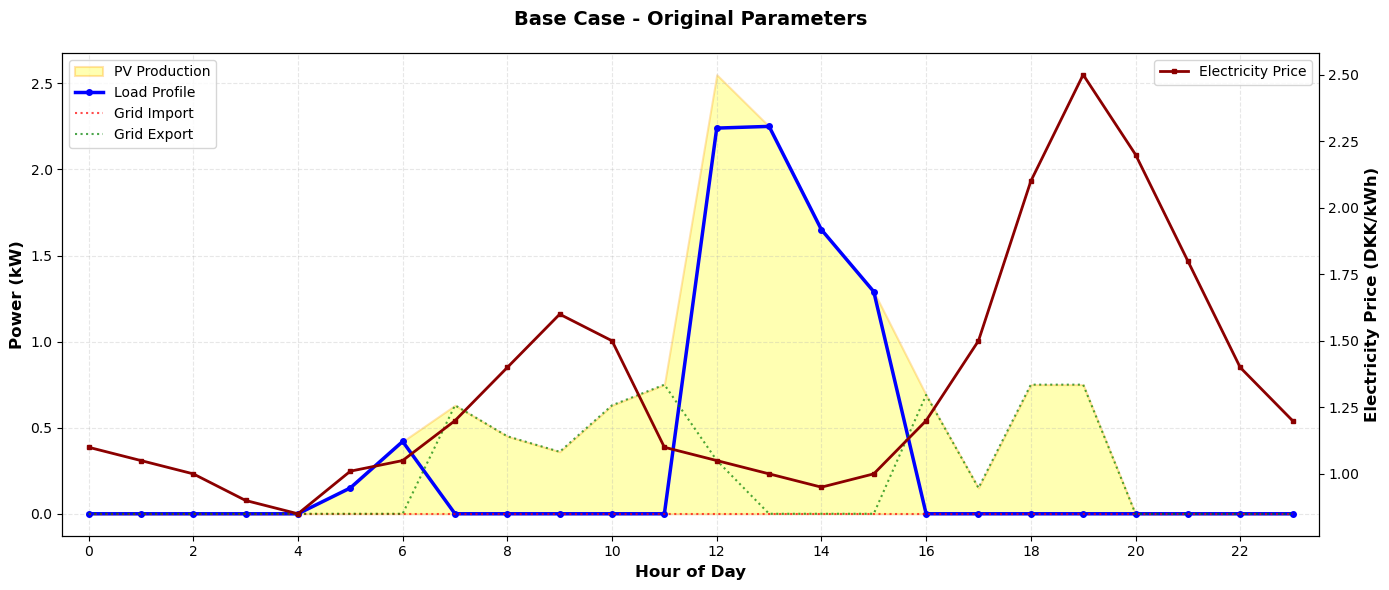

In [20]:
# Plot Base Case
plot_scenario_results(base_case_results, title="Base Case - Original Parameters")

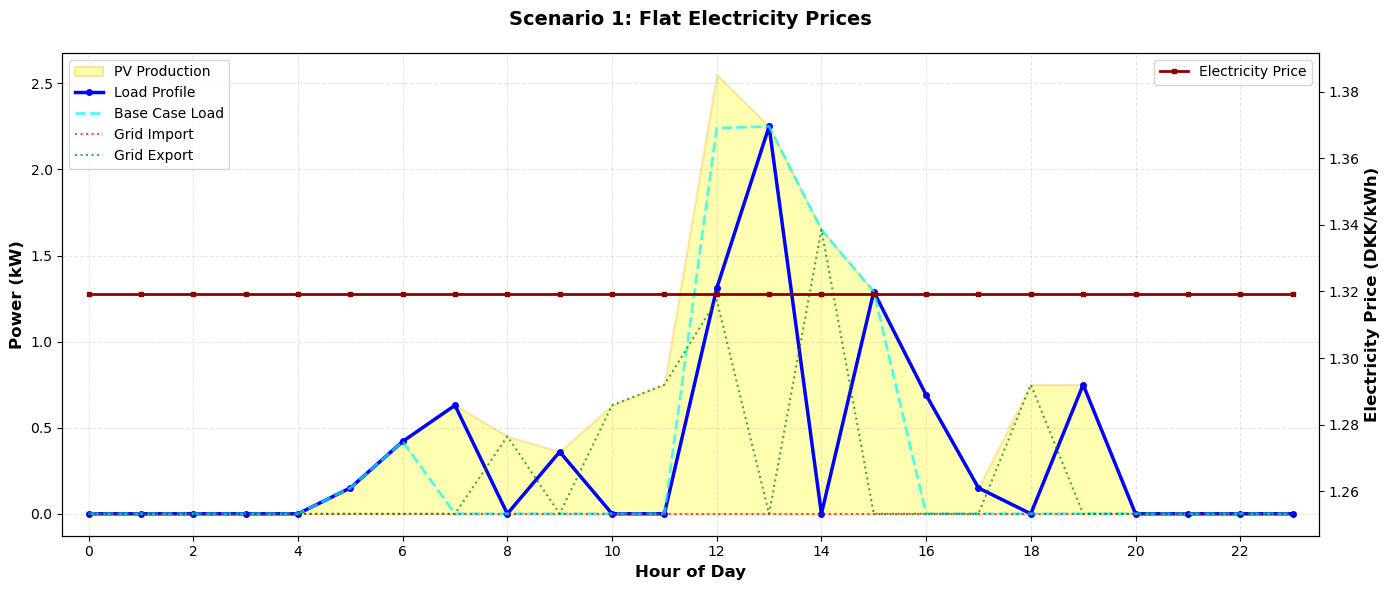

In [21]:
# Plot Scenario 1: Flat Electricity Prices
plot_scenario_results(results_scenario1, base_results=base_case_results, 
                     title="Scenario 1: Flat Electricity Prices")

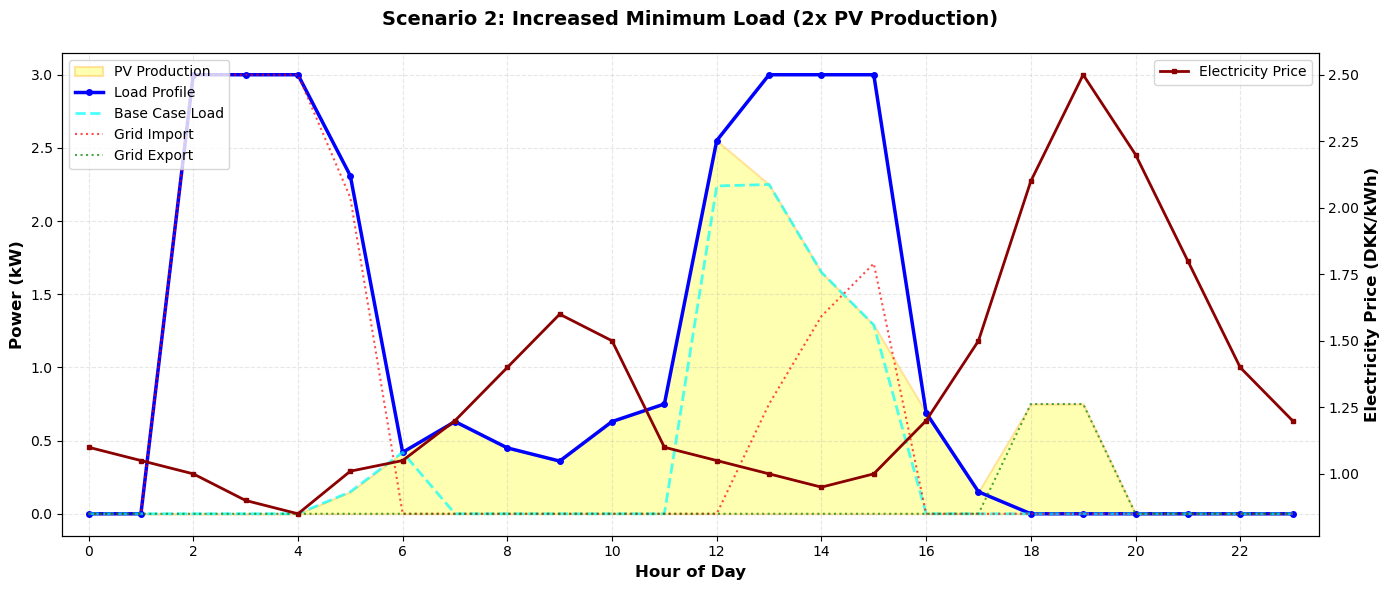

In [22]:
# Plot Scenario 2: Increased Minimum Load
plot_scenario_results(results_scenario2, base_results=base_case_results, 
                     title="Scenario 2: Increased Minimum Load (2x PV Production)")

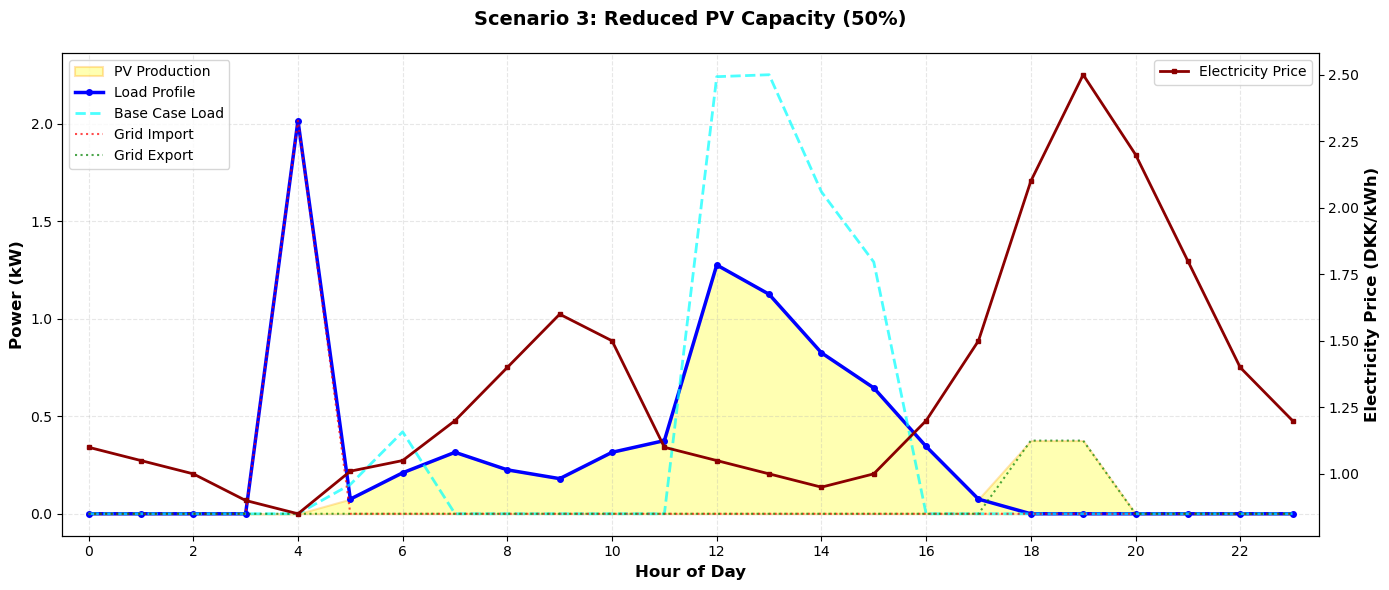

In [23]:
# Plot Scenario 3: Reduced PV Capacity
plot_scenario_results(results_scenario4, base_results=base_case_results, 
                     title="Scenario 3: Reduced PV Capacity (50%)")

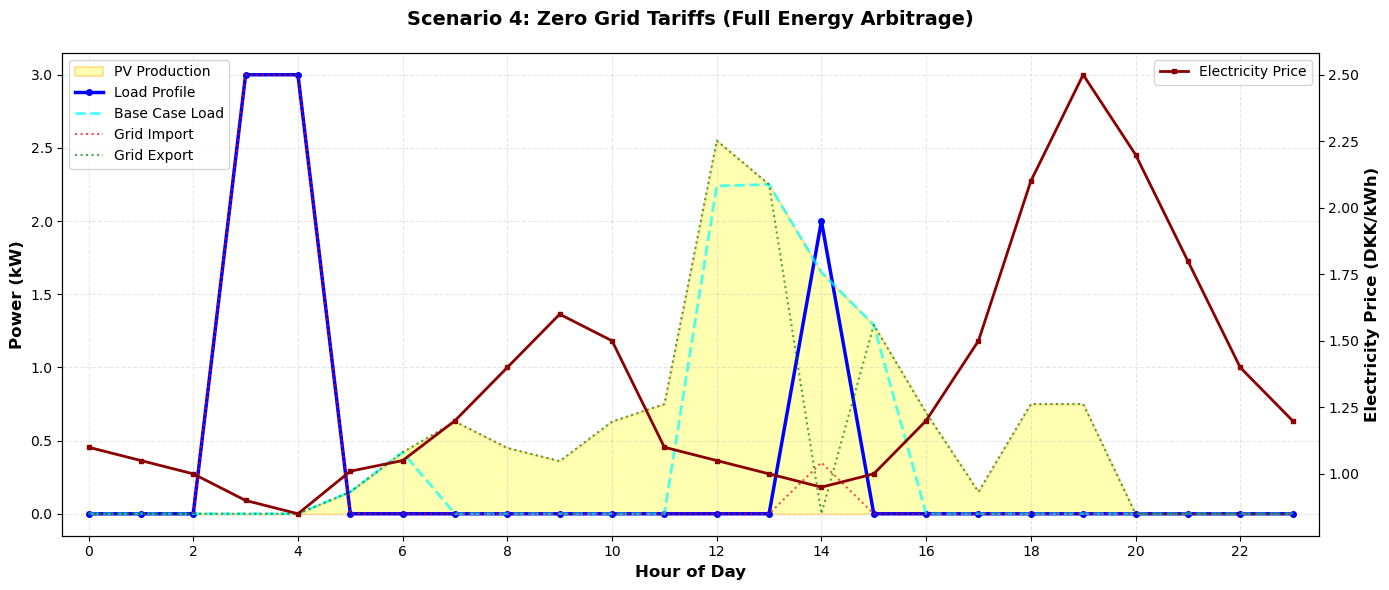

In [24]:
# Plot Scenario 4: Zero Grid Tariffs
plot_scenario_results(results_scenario5, base_results=base_case_results, 
                     title="Scenario 4: Zero Grid Tariffs (Full Energy Arbitrage)")

## Save All Plots

Save all generated plots to the Plots folder for documentation and reporting.

In [25]:
import os

# Create subfolder for sensitivity analysis plots
output_folder = './Plots/Scenarios a)/'
os.makedirs(output_folder, exist_ok=True)

# Function to save plots
def save_scenario_plot(results, base_results=None, title="Scenario Results", filename="plot.png"):
    """
    Generate and save plot to file
    """
    hours = range(len(results['load']))
    
    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    # Plot PV production (yellow filled area, semi-transparent)
    ax1.fill_between(hours, results['pv_production'], alpha=0.3, color='yellow', 
                     label='PV Production', edgecolor='orange', linewidth=1.5)
    
    # Plot load profile
    ax1.plot(hours, results['load'], color='blue', linewidth=2.5, 
             label='Load Profile', marker='o', markersize=4)
    
    # Plot base case load if provided
    if base_results is not None:
        ax1.plot(hours, base_results['load'], color='cyan', linewidth=2, 
                 linestyle='--', label='Base Case Load', alpha=0.7)
    
    # Optionally plot grid import/export
    if Grid_plot_var:
        ax1.plot(hours, results['grid_import'], color='red', linewidth=1.5, 
                 linestyle=':', label='Grid Import', alpha=0.7)
        ax1.plot(hours, results['grid_export'], color='green', linewidth=1.5, 
                 linestyle=':', label='Grid Export', alpha=0.7)
    
    ax1.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Power (kW)', fontsize=12, fontweight='bold')
    ax1.set_xlim(-0.5, 23.5)
    ax1.set_xticks(range(0, 24, 2))
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(loc='upper left', fontsize=10)
    
    # Create secondary y-axis for electricity prices
    ax2 = ax1.twinx()
    ax2.plot(hours, results['electricity_prices'], color='darkred', linewidth=2, 
             linestyle='-', marker='s', markersize=3, label='Electricity Price')
    ax2.set_ylabel('Electricity Price (DKK/kWh)', fontsize=12, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=10)
    
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    
    # Save to file
    filepath = os.path.join(output_folder, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved: {filepath}")

# Save all plots
print(f"Saving plots to: {output_folder}")
print("="*80)

save_scenario_plot(base_case_results, 
                  title="Base Case - Original Parameters",
                  filename="base_case.png")

save_scenario_plot(results_scenario1, base_results=base_case_results,
                  title="Scenario 1: Flat Electricity Prices",
                  filename="scenario_1_flat_prices.png")

save_scenario_plot(results_scenario2, base_results=base_case_results,
                  title="Scenario 2: Increased Minimum Load (2x PV Production)",
                  filename="scenario_2_increased_load.png")

save_scenario_plot(results_scenario4, base_results=base_case_results,
                  title="Scenario 3: Reduced PV Capacity (50%)",
                  filename="scenario_3_reduced_pv.png")

save_scenario_plot(results_scenario5, base_results=base_case_results,
                  title="Scenario 4: Zero Grid Tariffs (Full Energy Arbitrage)",
                  filename="scenario_4_zero_tariffs.png")

print("="*80)
print("All plots saved successfully!")

Saving plots to: ./Plots/Scenarios a)/
Saved: ./Plots/Scenarios a)/base_case.png
Saved: ./Plots/Scenarios a)/base_case.png
Saved: ./Plots/Scenarios a)/scenario_1_flat_prices.png
Saved: ./Plots/Scenarios a)/scenario_1_flat_prices.png
Saved: ./Plots/Scenarios a)/scenario_2_increased_load.png
Saved: ./Plots/Scenarios a)/scenario_2_increased_load.png
Saved: ./Plots/Scenarios a)/scenario_3_reduced_pv.png
Saved: ./Plots/Scenarios a)/scenario_3_reduced_pv.png
Saved: ./Plots/Scenarios a)/scenario_4_zero_tariffs.png
All plots saved successfully!
Saved: ./Plots/Scenarios a)/scenario_4_zero_tariffs.png
All plots saved successfully!
